# Data Preparation and Loading

In this notebook will be made a primary data exploration, a data preparation and a loading using 'ImageDataGenerator' tools from Keras.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from PIL import Image

IMG_WIDTH, IMG_HEIGHT = 128,128
CSV_PATH = '../data/pokemon.csv'
IMAGES_FOLDER = '../data/images/images'

/home/omar/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-19 15:55:18.632337: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 15:55:18.732911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 15:55:18.732942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 15:55:18.739316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS

## Data exploration

Pokemon CSV contains the names and the types of our pokemon.<br>
The types are in two separate columns. In some cases, the second column is empty.

In [2]:
df = pd.read_csv(CSV_PATH)
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


<br>Let's look at the label frequencies.

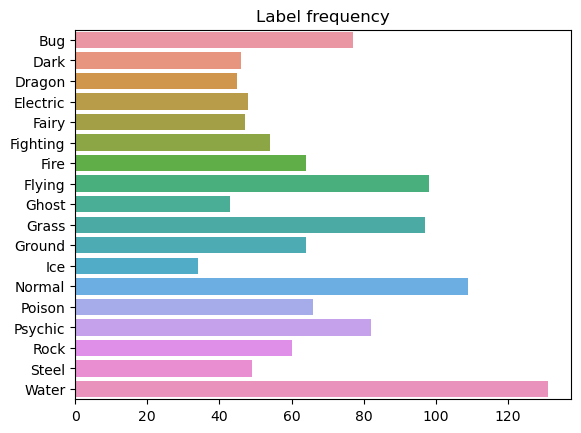

In [3]:
# Get label frequencies
type1_freq = df['Type1'].value_counts()
type2_freq = df['Type2'].value_counts()
label_freq = type1_freq.add(type2_freq, fill_value=0)

# Bar plot
plt.figure()
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency")
plt.show()

## Images

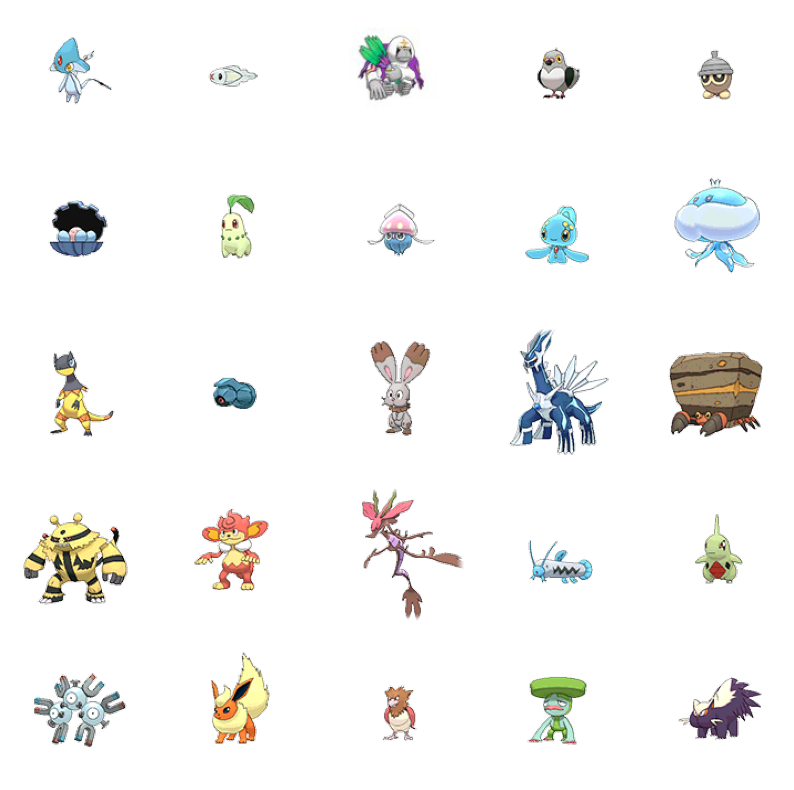

In [4]:
images_path = os.listdir(IMAGES_FOLDER)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.reshape(-1)):
    img_path = os.path.join(IMAGES_FOLDER, images_path[i])
    ax.imshow(Image.open(str(img_path)))
    ax.axis(False)

## Data Preparation

In [5]:
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


Let's create a labels column which contains a list of types for each pokemon.

In [6]:
def merge_types(row): 
    t1 = row['Type1']
    t2 = row['Type2']
    if t2 is np.nan: 
        return [t1]
    return [t1,t2]
    

df['labels'] = df.apply(lambda row: merge_types(row), axis=1)
df.head()

,Name,Type1,Type2,labels
0,bulbasaur,Grass,Poison,"[Grass, Poison]"
1,ivysaur,Grass,Poison,"[Grass, Poison]"
2,venusaur,Grass,Poison,"[Grass, Poison]"
3,charmander,Fire,NaN,[Fire]
4,charmeleon,Fire,NaN,[Fire]


Let's create a 'path' column which contains the path of the image.
<br>Problem : 2 possible extensions : '.png' and '.jpg'

In [7]:
def find_image_path_with_name(_name):
    if os.path.exists(os.path.join(IMAGES_FOLDER, _name+'.png')):
        return _name + '.png'
    else:
        return _name + '.jpg'
    

df['path'] = df.apply(lambda row: find_image_path_with_name(row['Name']), axis=1)
df.head()

,Name,Type1,Type2,labels,path
0,bulbasaur,Grass,Poison,"[Grass, Poison]",bulbasaur.png
1,ivysaur,Grass,Poison,"[Grass, Poison]",ivysaur.png
2,venusaur,Grass,Poison,"[Grass, Poison]",venusaur.png
3,charmander,Fire,NaN,[Fire],charmander.png
4,charmeleon,Fire,NaN,[Fire],charmeleon.png


Image size :

In [8]:
image_files = os.listdir(IMAGES_FOLDER)
image_path = os.path.join(IMAGES_FOLDER, image_files[13])
img = Image.open(image_path)
img.size

(120, 120)

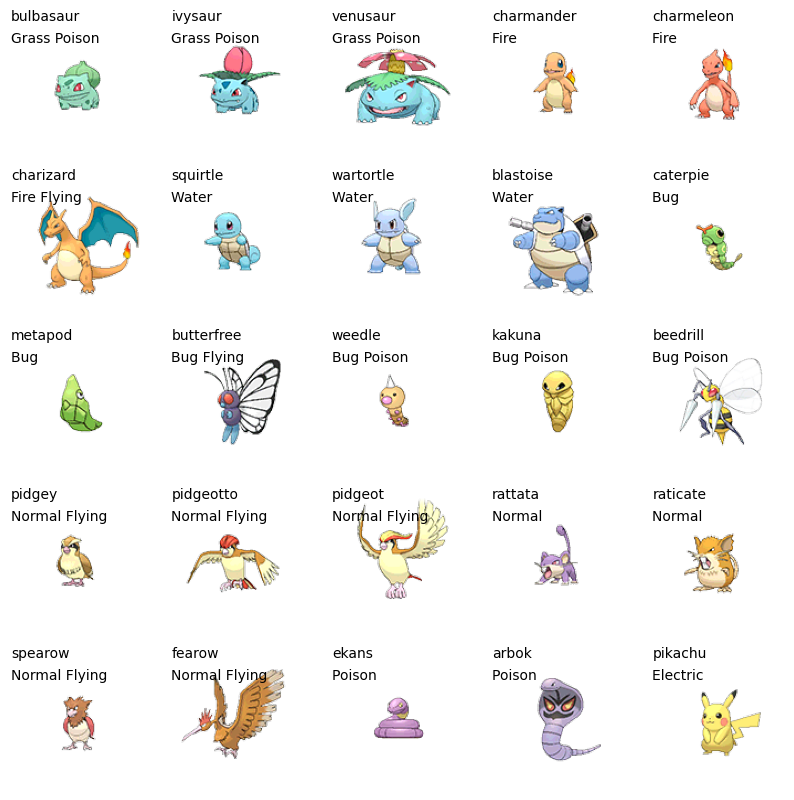

In [9]:
images_path = os.listdir(IMAGES_FOLDER)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.reshape(-1)):
    img_path = os.path.join(IMAGES_FOLDER, df['path'][i])
    ax.imshow(Image.open(str(img_path)))
    ax.text(0.5, 0.1, df['Name'][i])
    ax.text(0.5, 20, df['Type1'][i] + " " + str(df['Type2'][i]).replace('nan', ''))
    ax.axis(False)

## Data Loading

In [10]:
# Split the data into training and validation sets
train_df, temp_df = train_test_split(df, train_size=0.8, random_state=42)
validation_df, test_df =  train_test_split(temp_df, test_size=0.5, random_state=42)

# Normalization
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_FOLDER,
    x_col='path',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    #batch_size=?,
    class_mode='categorical',
    validate_filenames=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=IMAGES_FOLDER,
    x_col='path',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    #batch_size=?,
    class_mode='categorical',
    validate_filenames=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGES_FOLDER,
    x_col='path',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    #batch_size=?,
    class_mode='categorical',
    validate_filenames=True
)

Found 647 validated image filenames belonging to 18 classes.
Found 81 validated image filenames belonging to 18 classes.
Found 81 validated image filenames belonging to 18 classes.


In [11]:
# mapping of class indexes and labels
class_mapping = train_generator.class_indices
print("Mapping of class indexes and labels :", class_mapping, sep='\n')

# labels of the first image
first_image_labels = train_generator.classes[0]
print("\n", "Labels of the first image : ", first_image_labels)

Mapping of class indexes and labels :
{'Bug': 0, 'Dark': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6, 'Flying': 7, 'Ghost': 8, 'Grass': 9, 'Ground': 10, 'Ice': 11, 'Normal': 12, 'Poison': 13, 'Psychic': 14, 'Rock': 15, 'Steel': 16, 'Water': 17}

 Labels of the first image :  [14, 16]
